In [9]:
import json
import os
import re
import requests
from typing import Any, Literal
from PIL import Image, ImageDraw
from IPython.display import display
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize
from transformers import AutoModelForImageTextToText, AutoProcessor
from huggingface_hub import hf_hub_download

In [ ]:
HF_MODEL_REPO = "Hcompany/Holo1-3B"

In [11]:
# default: Load the model on the available device(s)
# We recommend enabling flash_attention_2 for better acceleration and memory saving.
model = AutoModelForImageTextToText.from_pretrained(
    HF_MODEL_REPO,
    torch_dtype="auto",
    # torch_dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2",
    device_map="auto",
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:36<00:00,  9.02s/it]
Some parameters are on the meta device because they were offloaded to the disk.


In [12]:
# default processor
processor = AutoProcessor.from_pretrained(HF_MODEL_REPO)
# The default range for the number of visual tokens per image in the model is 4-1280.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# processor = AutoProcessor.from_pretrained(model_dir, min_pixels=min_pixels, max_pixels=max_pixels)

In [13]:
# Helper function to run inference
def run_inference(messages: list[dict[str, Any]]) -> str:
    # Preparation for inference
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(
        text=[text],
        images=image,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("mps")

    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    return processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)

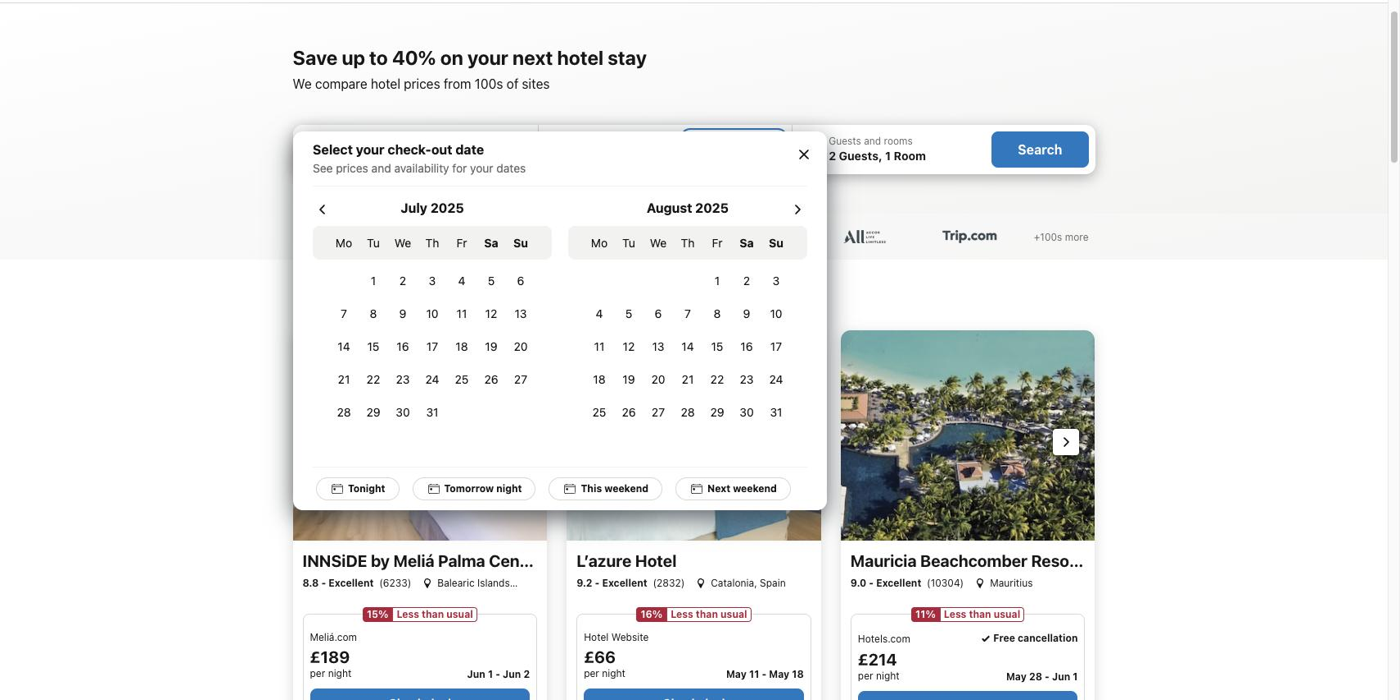

In [14]:
# Prepare image and instruction
image_url = "https://huggingface.co/{}/resolve/main/calendar_example.jpg".format(HF_MODEL_REPO) 
image = Image.open(requests.get(image_url, stream=True).raw)

# Resize the image so that predicted absolute coordinates match the size of the image.
image_processor = processor.image_processor
resized_height, resized_width = smart_resize(
    image.height,
    image.width,
    factor=image_processor.patch_size * image_processor.merge_size,
    min_pixels=image_processor.min_pixels,
    max_pixels=image_processor.max_pixels,
)
image = image.resize(size=(resized_width, resized_height), resample=None)  # type: ignore

display(image)

In [15]:
hf_hub_download(repo_id=HF_MODEL_REPO, filename="localization.py", local_dir=os.getcwd())
hf_hub_download(repo_id=HF_MODEL_REPO, filename="navigation.py", local_dir=os.getcwd())


'/Users/sauravkarki/intern/navigation.py'

In [17]:
import localization

instruction = "Select July 14th as the check-out date"
prompt = localization.get_localization_prompt(image, instruction)
coordinates = run_inference(prompt)[0]
print(coordinates)
# Expected Click(352, 348)

KeyboardInterrupt: 